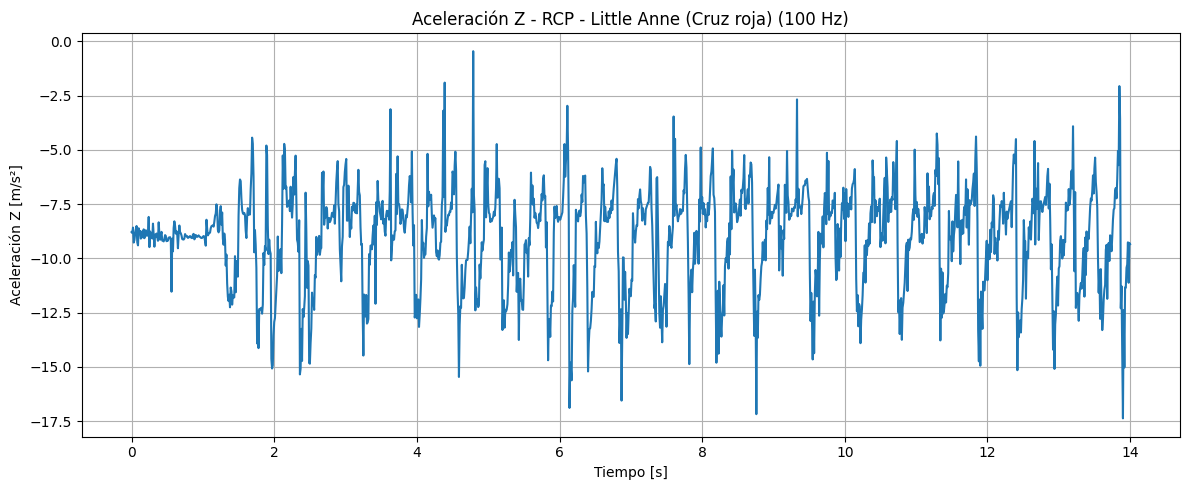

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Parámetros
fs = 100.0  # frecuencia de muestreo (Hz)
file = "C:/Users/Equipo/Documents/Proyecto_Final/flask _pruebas/simu/RCP_CR3.csv"  # o RCP_CR1.csv, RCP_CR2.csv, etc.

# Cargar el CSV
df = pd.read_csv(file)

# Si no tiene timestamp, generarlo
if "timestamp_s" not in df.columns:
    n = len(df)
    df["timestamp_s"] = np.arange(n) / fs

df = df[df["timestamp_s"] <= 14.0]
# Graficar la señal
plt.figure(figsize=(12, 5))
plt.plot(df["timestamp_s"], df["Aceleracion_Z"], color='tab:blue')
plt.title("Aceleración Z - RCP - Little Anne (Cruz roja) (100 Hz)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Aceleración Z [m/s²]")
plt.grid(True)
plt.tight_layout()
plt.show()

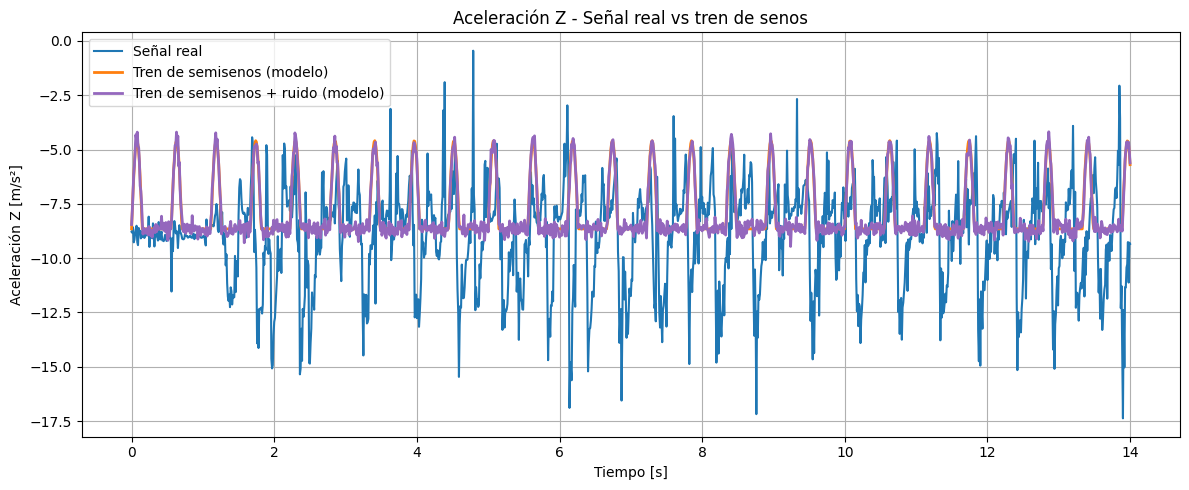

In [3]:
t = df["timestamp_s"].values
z = df["Aceleracion_Z"].values

# ==============================
# 2. Definir función modelo: tren de senos
# ==============================
def semi_sine_train(t, A, f, w, b):
    """
    Tren de semisenos con sesgo b:
    A: amplitud
    f: frecuencia (Hz)
    w: ancho del pulso (s)
    b: sesgo (m/s²)
    """
    T = 1.0 / f
    tau = np.mod(t, T)
    y = np.zeros_like(t)
    mask = tau <= w
    y[mask] = A * np.sin(np.pi * tau[mask] / w)
    return b + y

# ==============================
# 3. Ajustar parámetros básicos
# ==============================
# Estimaciones iniciales aproximadas
b = np.median(z)           # baseline (aprox. -g)
A = np.percentile(z - b, 98.9)
f = 1.8                    # frecuencia inicial (Hz)
w = 0.15                   # ancho del pulso (s)

# Generar el modelo
y_model = semi_sine_train(t, A, f, w, b)
ruido = np.random.normal(0, 0.21, size=len(y_model))
y_model_ruidoso = y_model + ruido

# ==============================
# 4. Graficar señal original vs modelo
# ==============================
plt.figure(figsize=(12, 5))
plt.plot(t, z, label="Señal real", color="tab:blue")
plt.plot(t, y_model, label="Tren de semisenos (modelo)", color="tab:orange", linewidth=2)
plt.plot(t, y_model_ruidoso, label="Tren de semisenos + ruido (modelo)", color="tab:purple", linewidth=2)
plt.title("Aceleración Z - Señal real vs tren de senos")
plt.xlabel("Tiempo [s]")
plt.ylabel("Aceleración Z [m/s²]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
median_z = np.median(z)
z_filtrada = np.copy(z)
z_filtrada[z < median_z] = median_z  # truncar valores superiores a la media

# ==============================
# 4. Correlación entre señal filtrada y modelo
# ==============================
corr_coef = np.corrcoef(z_filtrada, y_model)[0, 1]

corr_cross = np.correlate(z_filtrada - np.median(z_filtrada),
                          y_model - np.median(y_model),
                          mode='full')
lags = np.arange(-len(z_filtrada) + 1, len(z_filtrada))
lag_max = lags[np.argmax(corr_cross)]
time_shift = lag_max / fs

print(f"Coeficiente de correlación (Pearson): {corr_coef:.3f}")
print(f"Desfase máximo: {time_shift:.3f} s")


Coeficiente de correlación (Pearson): 0.078
Desfase máximo: -0.060 s


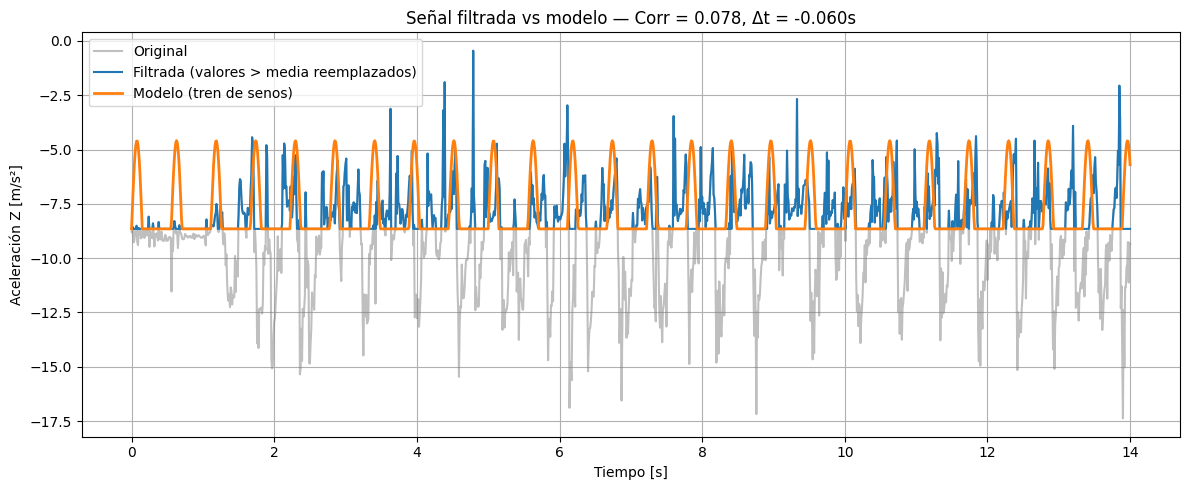

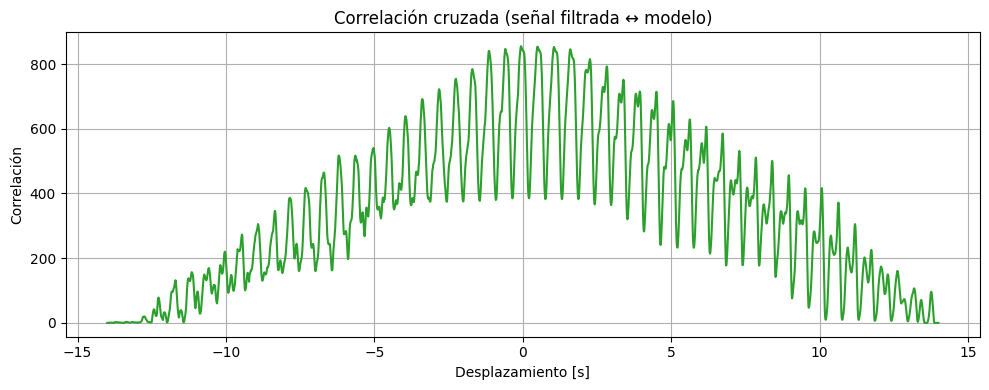

In [5]:
# 5. Graficar
# ==============================
plt.figure(figsize=(12, 5))
plt.plot(t, z, label="Original", color='gray', alpha=0.5)
plt.plot(t, z_filtrada, label="Filtrada (valores > media reemplazados)", color='tab:blue')
plt.plot(t, y_model, label="Modelo (tren de senos)", color='tab:orange', linewidth=2)
plt.title(f"Señal filtrada vs modelo — Corr = {corr_coef:.3f}, Δt = {time_shift:.3f}s")
plt.xlabel("Tiempo [s]")
plt.ylabel("Aceleración Z [m/s²]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Correlación cruzada
plt.figure(figsize=(10, 4))
plt.plot(lags / fs, corr_cross, color='tab:green')
plt.title("Correlación cruzada (señal filtrada ↔ modelo)")
plt.xlabel("Desplazamiento [s]")
plt.ylabel("Correlación")
plt.grid(True)
plt.tight_layout()
plt.show()

Coeficiente de correlación (Pearson): 0.077
Desfase máximo: 1.050 s


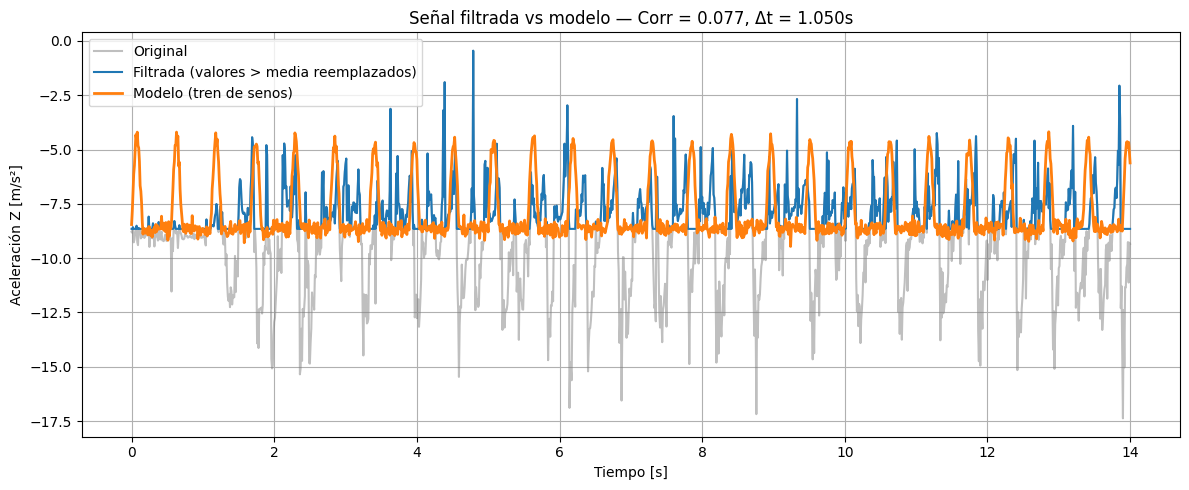

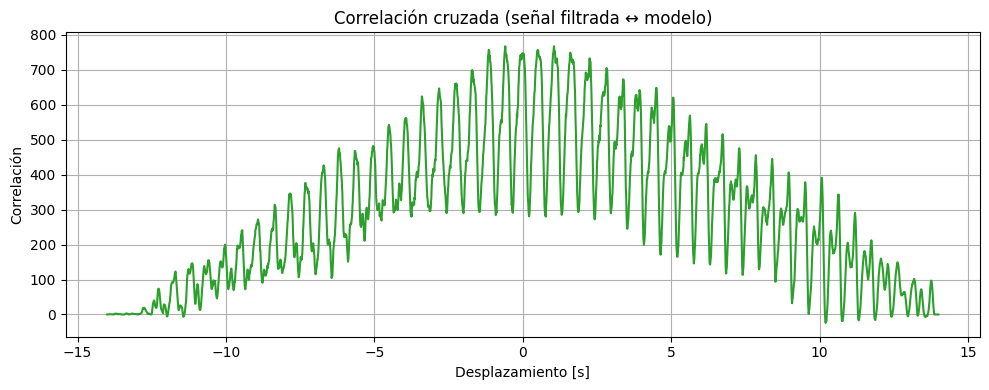

In [6]:

# ==============================
# 4. Correlación entre señal filtrada y modelo
# ==============================
corr_coef = np.corrcoef(z_filtrada, y_model_ruidoso)[0, 1]

corr_cross = np.correlate(z_filtrada - np.median(z_filtrada),
                          y_model_ruidoso - np.median(y_model_ruidoso),
                          mode='full')
lags = np.arange(-len(z_filtrada) + 1, len(z_filtrada))
lag_max = lags[np.argmax(corr_cross)]
time_shift = lag_max / fs

print(f"Coeficiente de correlación (Pearson): {corr_coef:.3f}")
print(f"Desfase máximo: {time_shift:.3f} s")


# 5. Graficar
# ==============================
plt.figure(figsize=(12, 5))
plt.plot(t, z, label="Original", color='gray', alpha=0.5)
plt.plot(t, z_filtrada, label="Filtrada (valores > media reemplazados)", color='tab:blue')
plt.plot(t, y_model_ruidoso, label="Modelo (tren de senos)", color='tab:orange', linewidth=2)
plt.title(f"Señal filtrada vs modelo — Corr = {corr_coef:.3f}, Δt = {time_shift:.3f}s")
plt.xlabel("Tiempo [s]")
plt.ylabel("Aceleración Z [m/s²]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Correlación cruzada
plt.figure(figsize=(10, 4))
plt.plot(lags / fs, corr_cross, color='tab:green')
plt.title("Correlación cruzada (señal filtrada ↔ modelo)")
plt.xlabel("Desplazamiento [s]")
plt.ylabel("Correlación")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
# ==============================
#  Guardar modelo en CSV
# ==============================

import pandas as pd

# Elegí qué versión guardar (sin o con ruido)
# y_model_ruidoso  → si agregaste ruido
# y_model          → si es el modelo limpio

df_model = pd.DataFrame({
    "timestamp_s": t,
    "Aceleracion_Z_modelo": y_model_ruidoso  # o y_model
})

df_model.to_csv("modelo_tren_senos_ruido_2.csv", index=False)
print("✅ Archivo guardado como modelo_tren_senos.csv")


✅ Archivo guardado como modelo_tren_senos.csv


Cantidad de picos detectados: 26


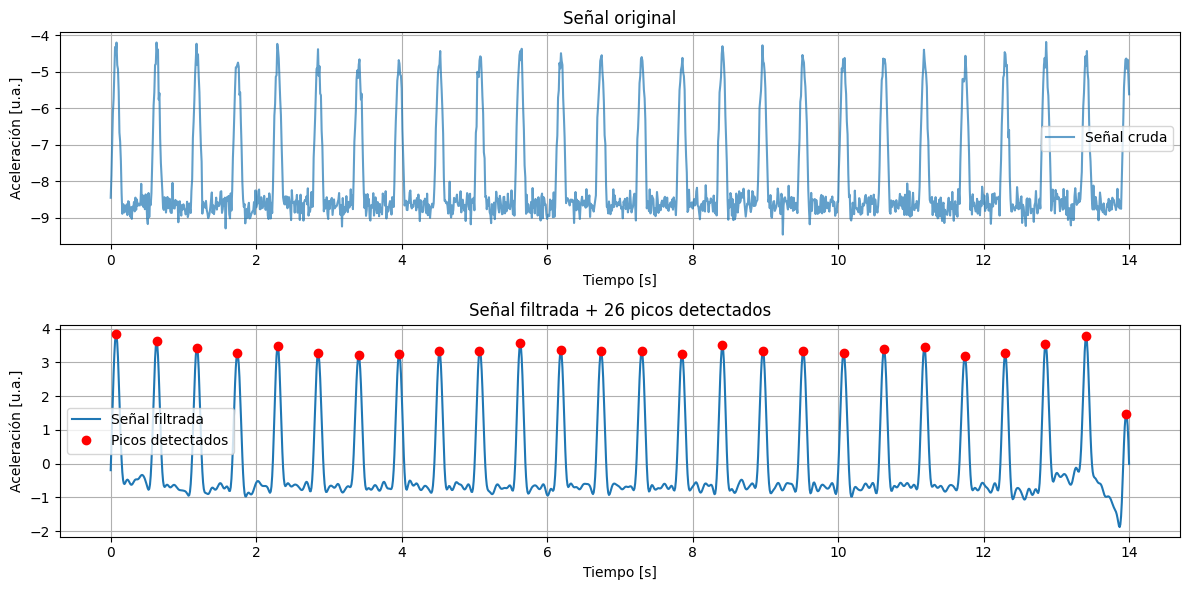

In [8]:
from scipy.signal import butter, filtfilt, find_peaks, savgol_filter
import numpy as np
import matplotlib.pyplot as plt

fs = 100.0
x=y_model_ruidoso

# --- Filtro bandpass más ancho ---
low, high = 0.5/(fs/2), 12.0/(fs/2)
b_bp, a_bp = butter(4, [low, high], btype='bandpass')
x_bp = filtfilt(b_bp, a_bp, x)

# --- Suavizado más leve ---
x_filt = savgol_filter(x_bp, window_length=11, polyorder=3)

# --- Detección de picos ---
min_sep = int(fs * 0.30)   # 0.4 s -> hasta 150 cpm
prom = 0.3 * np.std(x_filt)
peaks, props = find_peaks(x_filt, distance=min_sep, prominence=prom)

t = np.arange(len(x)) / fs
print(f"Cantidad de picos detectados: {len(peaks)}")

# --- Gráfico ---
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plt.plot(t, x, label="Señal cruda", alpha=0.7)
plt.title("Señal original")
plt.xlabel("Tiempo [s]")
plt.ylabel("Aceleración [u.a.]")
plt.grid(True)
plt.legend()

plt.subplot(2,1,2)
plt.plot(t, x_filt, label="Señal filtrada")
plt.plot(t[peaks], x_filt[peaks], 'ro', label="Picos detectados")
plt.title(f"Señal filtrada + {len(peaks)} picos detectados")
plt.xlabel("Tiempo [s]")
plt.ylabel("Aceleración [u.a.]")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Mejor correlación Pearson: 0.1845
Frecuencia óptima: 1.7720 Hz  (~106.32 cpm)
Defasaje óptimo:  0.390 s
Ancho del pulso óptimo:  0.220 s
Parámetros fijos: A=2.868 m/s², b=-8.653 m/s²


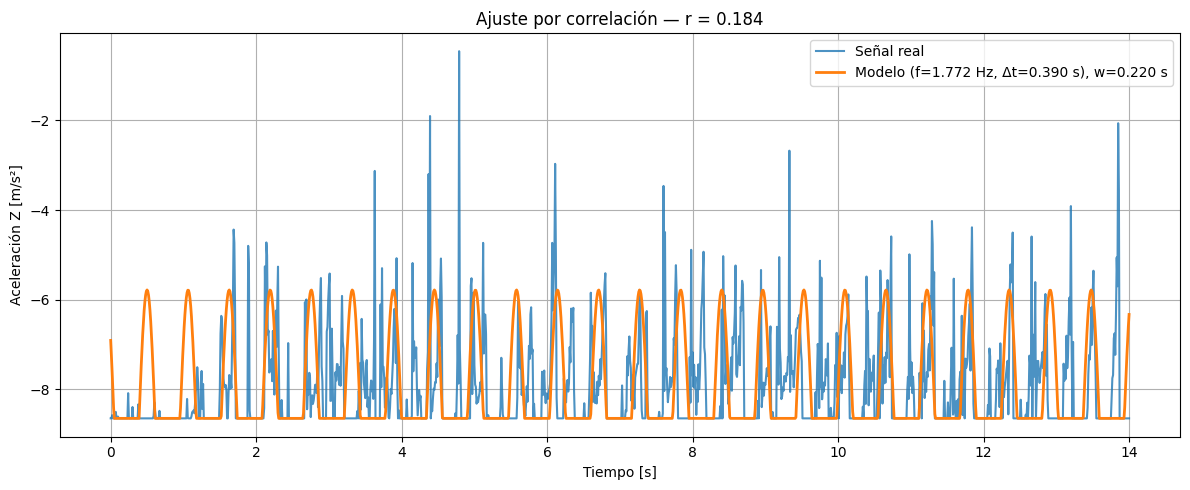

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
z=z_filtrada

# === 2) Modelo: tren de semisenos con defasaje =================
def semi_sine_train(t, A, f, w, b, phase_shift=0.0):
    """
    Tren de semisenos:
      - A: amplitud
      - f: frecuencia (Hz)
      - w: ancho de pulso (s)
      - b: sesgo (m/s²)
      - phase_shift: desfase temporal (s); positivo = retrasa el tren
    """
    T = 1.0 / f
    tau = np.mod(t - phase_shift, T)
    y = np.zeros_like(t)
    mask = tau <= w
    y[mask] = A * np.sin(np.pi * tau[mask] / w)
    return b + y

# === 3) Estimar parámetros fijos A, w, b =======================
b = float(np.median(z))                    # sesgo ~ -g
A = float(np.percentile(z - b, 95))        # amplitud típica de picos positivos
w = 0.18                                   # duración de la compresión (ajustable)

# === 4) Búsqueda en grilla f ∈ [1.6, 2.0], phase ∈ [0.1, 0.4] ==
f_grid = np.linspace(1.6, 2.0, 401)        # paso 0.001 Hz
phase_grid = np.linspace(0.1, 0.4, 61)     # paso 0.005 s
A_grid = np.linspace(A*0.8, A*1.2, 21)   # A ±20%
w_grid = np.linspace(0.16, 0.22, 25)     # rango de duraciones del pul

best_corr = -np.inf
best = None

for w_test in w_grid:
        for f in f_grid:
            for ph in phase_grid:
                y = semi_sine_train(t, A, f, w_test, b, phase_shift=ph)
                c = np.corrcoef(z, y)[0, 1]

                if c > best_corr:
                    best_corr = c
                    best = (w_test, f, ph)
                    y_best = y.copy()


w_best, f_best, ph_best = best

print(f"Mejor correlación Pearson: {best_corr:.4f}")
print(f"Frecuencia óptima: {f_best:.4f} Hz  (~{60*f_best:.2f} cpm)")
print(f"Defasaje óptimo:  {ph_best:.3f} s")
print(f"Ancho del pulso óptimo:  {w_best:.3f} s")
print(f"Parámetros fijos: A={A:.3f} m/s², b={b:.3f} m/s²")

# === 5) Graficar comparación ===================================
plt.figure(figsize=(12,5))
plt.plot(t, z, label="Señal real", alpha=0.8)
plt.plot(t, y_best, label=f"Modelo (f={f_best:.3f} Hz, Δt={ph_best:.3f} s), w={w_best:.3f} s", linewidth=2)
plt.title(f"Ajuste por correlación — r = {best_corr:.3f}")
plt.xlabel("Tiempo [s]")
plt.ylabel("Aceleración Z [m/s²]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


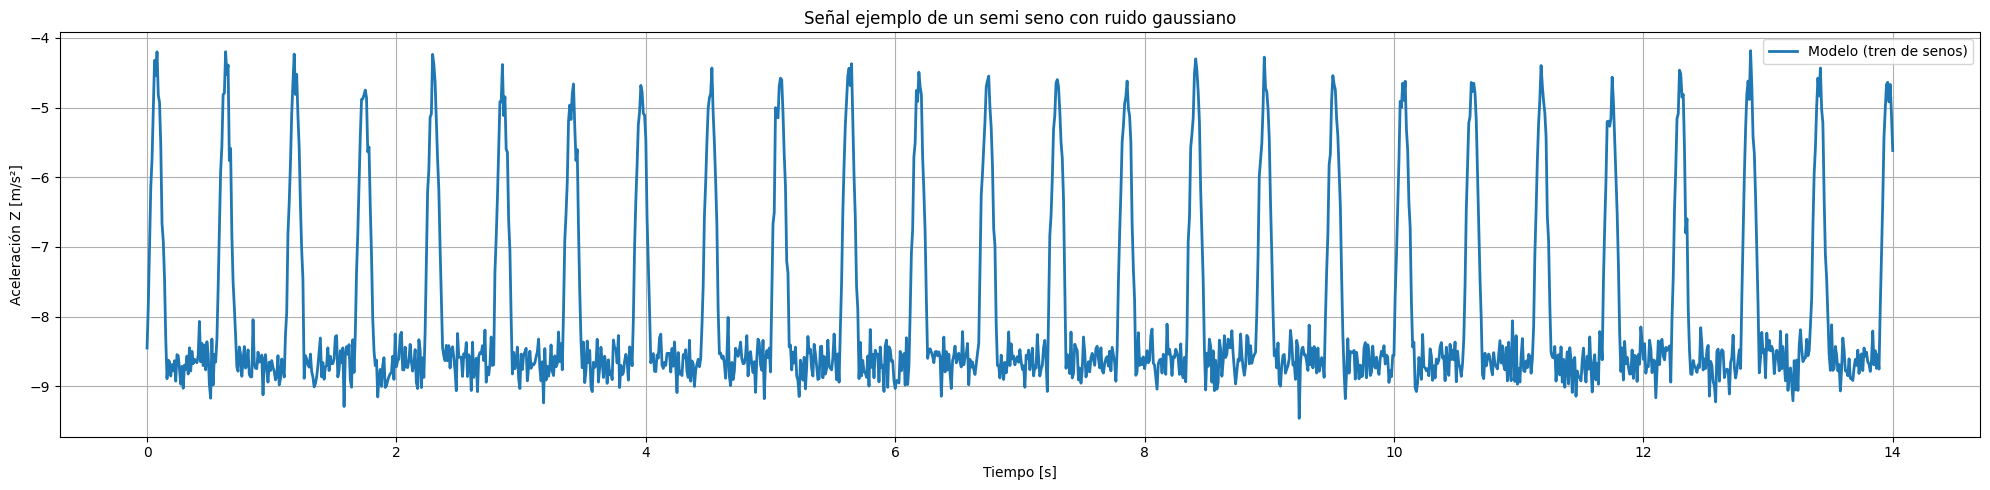

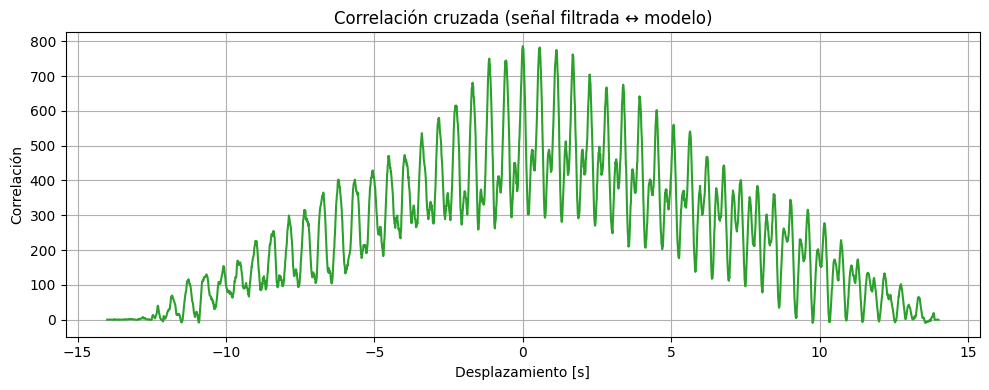

In [40]:

# 5. Graficar
# ==============================
plt.figure(figsize=(20, 5))
plt.plot(t, y_model_ruidoso, label="Modelo (tren de senos)", color='tab:blue', linewidth=2)
plt.title("Señal ejemplo de un semi seno con ruido gaussiano")
plt.xlabel("Tiempo [s]")
plt.ylabel("Aceleración Z [m/s²]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Correlación cruzada
plt.figure(figsize=(10, 4))
plt.plot(lags / fs, corr_cross, color='tab:green')
plt.title("Correlación cruzada (señal filtrada ↔ modelo)")
plt.xlabel("Desplazamiento [s]")
plt.ylabel("Correlación")
plt.grid(True)
plt.tight_layout()
plt.show()

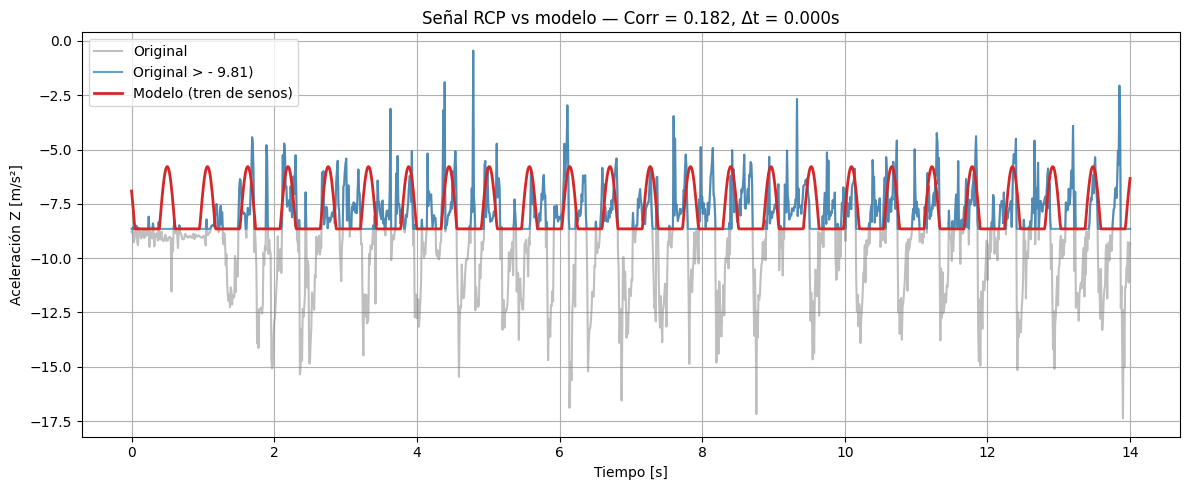

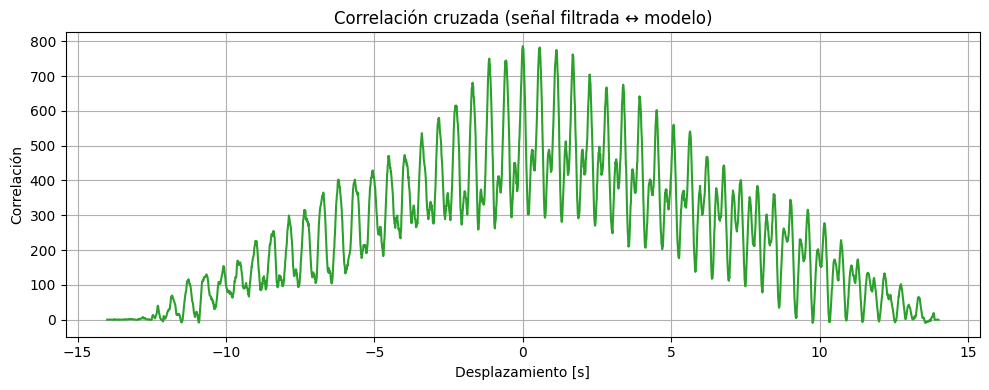

In [34]:

# 5. Graficar
# ==============================
z = df["Aceleracion_Z"].values
plt.figure(figsize=(12, 5))
plt.plot(t, z, label="Original", color='gray', alpha=0.5)
plt.plot(t, z_filtrada, label="Original > - 9.81)", color='tab:blue',  alpha=0.7)
plt.plot(t, y_best, label="Modelo (tren de senos)", color='tab:red', linewidth=2)
plt.title(f"Señal RCP vs modelo — Corr = {corr_coef:.3f}, Δt = {time_shift:.3f}s")
plt.xlabel("Tiempo [s]")
plt.ylabel("Aceleración Z [m/s²]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Correlación cruzada
plt.figure(figsize=(10, 4))
plt.plot(lags / fs, corr_cross, color='tab:green')
plt.title("Correlación cruzada (señal filtrada ↔ modelo)")
plt.xlabel("Desplazamiento [s]")
plt.ylabel("Correlación")
plt.grid(True)
plt.tight_layout()
plt.show()

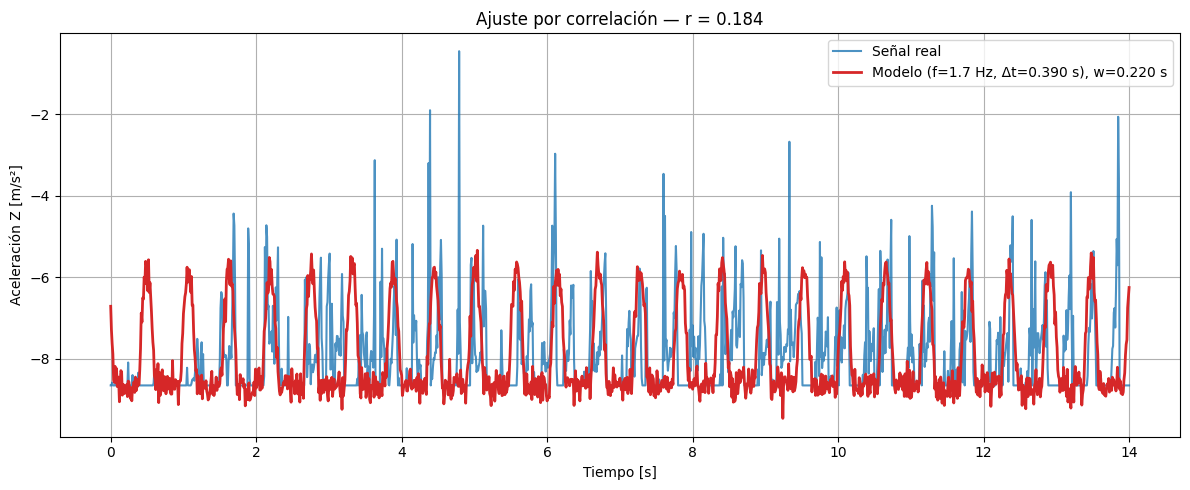

In [38]:
y_best_ruidoso = y_best + ruido
plt.figure(figsize=(12,5))
plt.plot(t, z_filtrada, label="Señal real", alpha=0.8)
plt.plot(t, y_best_ruidoso, label=f"Modelo (f=1.7 Hz, Δt={ph_best:.3f} s), w={w_best:.3f} s", linewidth=2, color="tab:red")
plt.title(f"Ajuste por correlación — r = {best_corr:.3f}")
plt.xlabel("Tiempo [s]")
plt.ylabel("Aceleración Z [m/s²]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Coeficiente de correlación (Pearson): 0.182
Desfase máximo: 0.000 s


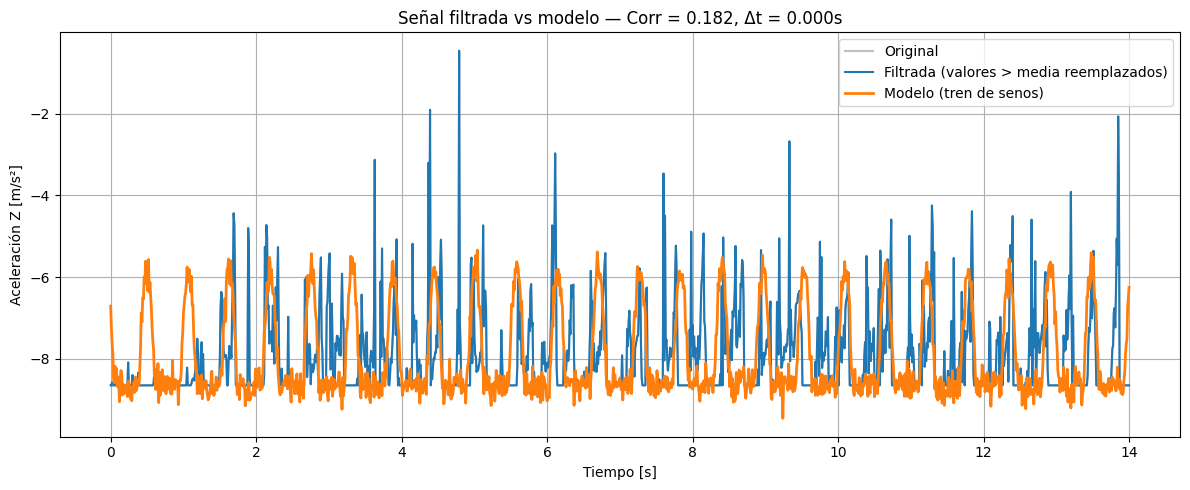

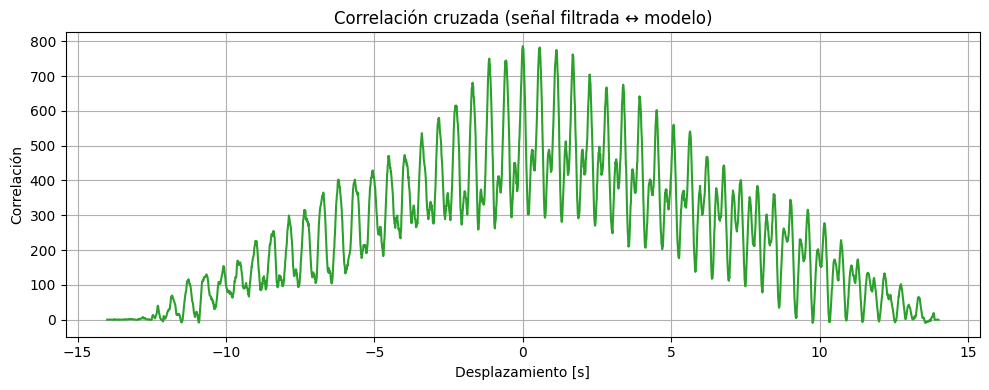

In [16]:
corr_coef = np.corrcoef(z_filtrada, y_best_ruidoso)[0, 1]

corr_cross = np.correlate(z_filtrada - np.median(z_filtrada),
                          y_best_ruidoso - np.median(y_best_ruidoso),
                          mode='full')
lags = np.arange(-len(z_filtrada) + 1, len(z_filtrada))
lag_max = lags[np.argmax(corr_cross)]
time_shift = lag_max / fs

print(f"Coeficiente de correlación (Pearson): {corr_coef:.3f}")
print(f"Desfase máximo: {time_shift:.3f} s")


# 5. Graficar
# ==============================
plt.figure(figsize=(12, 5))
plt.plot(t, z, label="Original", color='gray', alpha=0.5)
plt.plot(t, z_filtrada, label="Filtrada (valores > media reemplazados)", color='tab:blue')
plt.plot(t, y_best_ruidoso, label="Modelo (tren de senos)", color='tab:orange', linewidth=2)
plt.title(f"Señal filtrada vs modelo — Corr = {corr_coef:.3f}, Δt = {time_shift:.3f}s")
plt.xlabel("Tiempo [s]")
plt.ylabel("Aceleración Z [m/s²]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Correlación cruzada
plt.figure(figsize=(10, 4))
plt.plot(lags / fs, corr_cross, color='tab:green')
plt.title("Correlación cruzada (señal filtrada ↔ modelo)")
plt.xlabel("Desplazamiento [s]")
plt.ylabel("Correlación")
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
df_model = pd.DataFrame({
    "timestamp_s": t,
    "Aceleracion_Z_modelo": y_best_ruidoso  # o y_model
})

df_model.to_csv("modelo_tren_senos_ruido_2.csv", index=False)
print("✅ Archivo guardado como modelo_tren_senos.csv")

✅ Archivo guardado como modelo_tren_senos.csv


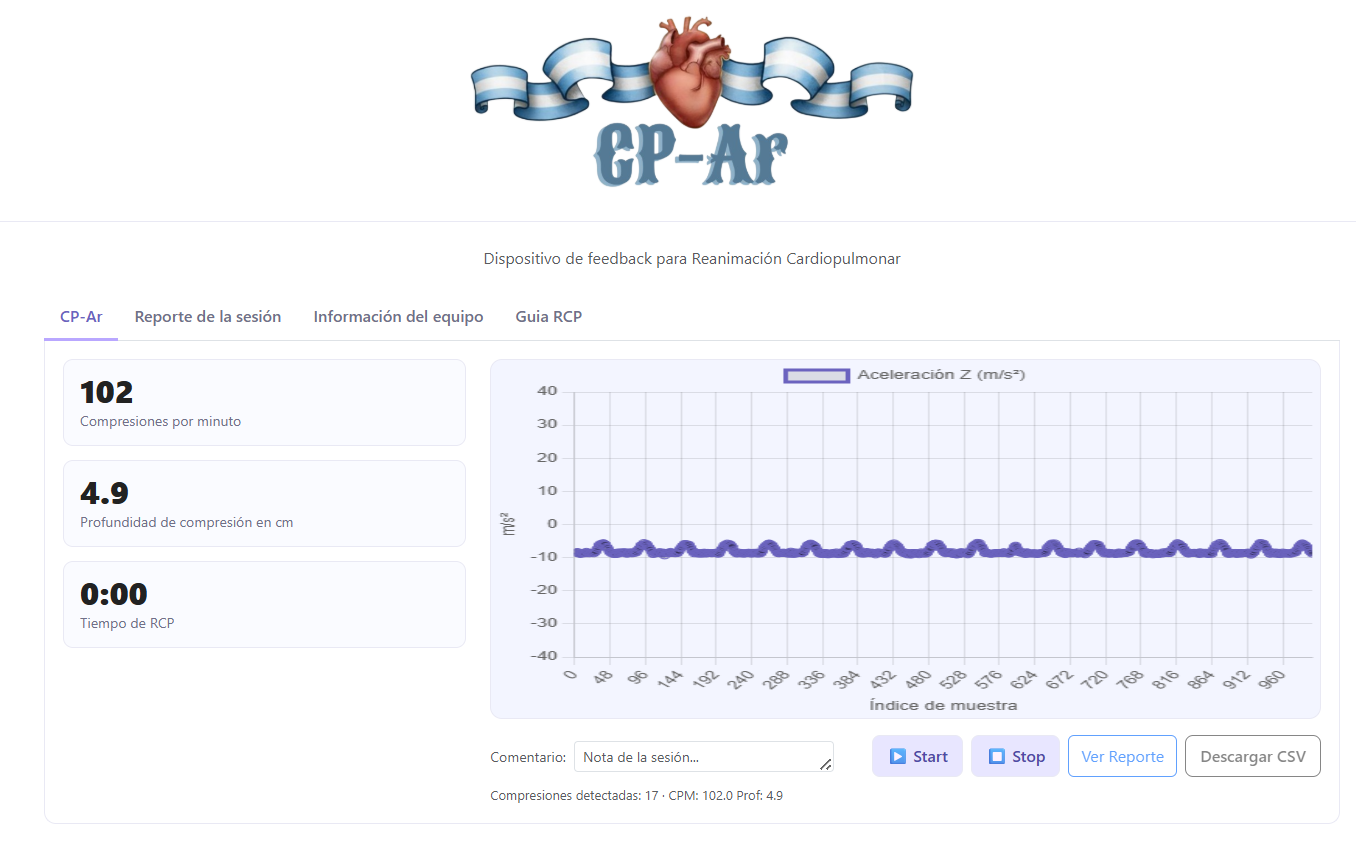